<h3 style="text-align: center;"><b>2 сценарий</b></h3>

In [ ]:
!nvidia-smi

Wed Jul  1 19:35:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


> Загрузка датасета. Был использован датасет "Фрукты" https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection к которому добавлены и размечены val сэмплы и ~200 дополнительных сэмплов для train.

>1 закоменченная ссылка - базовый датасет с каггла

>2 - "кастомный" расширенный



In [ ]:
# https://drive.google.com/file/d/1eEwtHCxB6vgY2tOr9I9vljdkR06mM6PP/view?usp=sharing base dataset `fruits_detection.zip`
# https://drive.google.com/file/d/1R4xq-KG5JI0dlAmqVUnqtJtXD6uxGSqT/view?usp=sharing extended `fruits.zip`
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1R4xq-KG5JI0dlAmqVUnqtJtXD6uxGSqT' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1R4xq-KG5JI0dlAmqVUnqtJtXD6uxGSqT" -O fruits.zip && rm -rf /tmp/cookies.txt

--2020-07-01 19:36:07--  https://docs.google.com/uc?export=download&confirm=y0Rw&id=1R4xq-KG5JI0dlAmqVUnqtJtXD6uxGSqT
Resolving docs.google.com (docs.google.com)... 108.177.125.139, 108.177.125.113, 108.177.125.101, ...
Connecting to docs.google.com (docs.google.com)|108.177.125.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-4o-docs.googleusercontent.com/docs/securesc/q675grdrh6rcg0tlrlm60qmtv94i8sos/ho9gl590l7gbtp4v4o40arkopivf763f/1593632100000/09392897364473027852/10139626534492698799Z/1R4xq-KG5JI0dlAmqVUnqtJtXD6uxGSqT?e=download [following]
--2020-07-01 19:36:07--  https://doc-0o-4o-docs.googleusercontent.com/docs/securesc/q675grdrh6rcg0tlrlm60qmtv94i8sos/ho9gl590l7gbtp4v4o40arkopivf763f/1593632100000/09392897364473027852/10139626534492698799Z/1R4xq-KG5JI0dlAmqVUnqtJtXD6uxGSqT?e=download
Resolving doc-0o-4o-docs.googleusercontent.com (doc-0o-4o-docs.googleusercontent.com)... 64.233.188.132, 2404:6800:4008:c06::84
Connec

In [ ]:
!unzip -q "/content/fruits.zip"

In [ ]:
!ls

drive  fruits.zip  sample_data	test_zip  train_zip  val_zip


> Функция, которая получает на вход .xml файл с PASCAL-VOC разметкой bbox'ов и возвращает list, состоящий из координат боксов 

In [ ]:
import xml.etree.ElementTree as ET

def xml_to_list(path):
    xml_list = []
    for xml_file in glob.glob(path):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    return xml_list

> Вместо torchvision.transforms будем использовать albumentations, т.к. albumentations применяются и к bbox'ам

In [ ]:
! pip install -U albumentations

     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 634kB 8.7MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64378 sha256=7769a2c6ad3ee0add09da5442ed1c51c61b1d69646cb89dfe297bf07f2fd69fa
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=ae46c279c2e7691e298a695879d941901745278624e486c7f816eb9511f65909
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


> Класс Dataset для предобработки данных

In [ ]:
import os
import numpy as np
import torch
import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader

import albumentations as albu
from albumentations.pytorch import ToTensor

# Для воспроизводимости результатов
SEED = 42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)


class PrepareDataset(Dataset):
    def __init__(self, root, mode):
        self.root = root
        self.mode = mode
        

        self.imgs = list(sorted(glob.glob(os.path.join(root + '/*.jpg'))))
        self.boxes = list(sorted(glob.glob(os.path.join(root + '/*.xml'))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.imgs[idx])
        box_path = os.path.join(self.root, self.boxes[idx])
        img = Image.open(img_path).convert("RGB")
        img = np.asarray(img)
        box_list = xml_to_list(box_path)

        annotations = {'image': img,
                       'bboxes': [],
                       'category_id': []}
        for i in range(len(box_list)):
            xmin = box_list[i][4]
            xmax = box_list[i][6]
            ymin = box_list[i][5]
            ymax = box_list[i][7]
            label = box_list[i][3]
            if label == 'apple':
                annotations['category_id'].append(1)
            elif label == 'banana':
                annotations['category_id'].append(2)
            else:
                annotations['category_id'].append(3)
            annotations['bboxes'].append([xmin, ymin, xmax, ymax])
        
        if self.mode == 'train':
            self.transforms = [albu.HorizontalFlip(),
                               albu.Flip()]
        else:
            self.transforms = []

        # Дополнительные аугментации для 'banana' в train т.к. этот класс детектируется хуже остальных
        if any(label == 2 for label in annotations['category_id']) and self.mode == 'train':
            self.transforms.append(albu.RandomGamma(p=1))
            self.transforms.append(albu.RandomBrightness(limit=0.1))
            self.transforms.append(albu.RandomContrast(limit=0.15))
        
        self.transforms.append(ToTensor())
        self.transforms = albu.Compose(self.transforms, bbox_params=albu.BboxParams(format='pascal_voc', label_fields=['category_id'])) 
        if self.transforms is not None:
            annotations = self.transforms(**annotations)
        
        boxes = []
        for i, box in enumerate(annotations['bboxes']):
            annotations['bboxes'][i] = list(box)

        boxes = torch.as_tensor(annotations['bboxes'], dtype=torch.float32)

        image = annotations['image']
        target = {}
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.as_tensor(annotations['category_id'], dtype=torch.int64)

        return {'I': image,
                'T': target}

    def __len__(self):
        return len(self.imgs)

> Использована предобученная Faster RCNN сеть

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# 3 classes (apple, banana, orange) + background
num_classes = 3 + 1
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model = model.cuda()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


> collate_fn для того, чтобы собрать batch. Стандартный collate_fn работает только с картинками одинаковых размерностей.

In [ ]:
def collate_fn(batch):
    return batch

> Создаем даталоадеры для train, val и test выборки. 

In [ ]:
DIR_train = '/content/train_zip/train'
DIR_val = '/content/val_zip/val'
DIR_test = '/content/test_zip/test'
dataset_train = PrepareDataset(DIR_train, mode='train')
data_loader_train = torch.utils.data.DataLoader(
 dataset_train, batch_size=5, shuffle=True, collate_fn=collate_fn)
dataset_val = PrepareDataset(DIR_val, mode='val')
data_loader_val = torch.utils.data.DataLoader(
 dataset_val, batch_size=1, shuffle=False, collate_fn=collate_fn)
dataset_test = PrepareDataset(DIR_test, mode='test')
data_loader_test = torch.utils.data.DataLoader(
 dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [ ]:
print('Amount of train samples = ', len(dataset_train))
print('Amount of val samples = ', len(dataset_val))
print('Amount of test samples = ', len(dataset_test))

Amount of train samples =  456
Amount of val samples =  50
Amount of test samples =  50


> Функции отрисовки боксов на изображениях.

In [ ]:
import cv2
import matplotlib.pyplot as plt


BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)


def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
    x_min, y_min, x_max, y_max = bbox
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[int(class_id)]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(image, target, category_id_to_name={1: 'apple', 2: 'banana', 3: 'orange'}):
    img = image.cpu().numpy().transpose(1, 2, 0).copy()
    for idx, box in enumerate(target['boxes']):
        img = visualize_bbox(img, box, target['labels'][idx], category_id_to_name, color=BOX_COLOR, thickness=2)
    plt.figure(figsize=(12, 12))
    plt.imshow(img)

> Отобразим одну картинку с размеченными боксами для примера

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


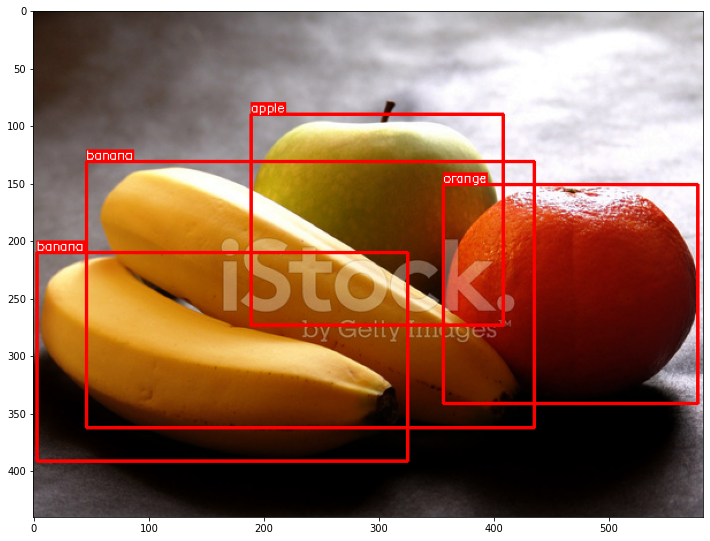

In [ ]:
sample = dataset_train.__getitem__(11)
sample_image = sample['I']
sample_target = sample['T']
# test_real_B_data = data_test.__getitem__(39)['B'].unsqueeze(0)
visualize(sample_image, sample_target)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [5, 10, 15, 25], gamma=0.1)

In [ ]:
def train(model, optimizer, lr_scheduler, epochs, saving_freq): 
    model.train()
    losses_history_train = {'loss_classifier': [],
                       'loss_box_reg': [],
                       'loss_objectness': [],
                       'loss_rpn_box_reg': []}
    losses_history_val = {'loss_classifier': [],
                       'loss_box_reg': [],
                       'loss_objectness': [],
                       'loss_rpn_box_reg': []}
                       
    for epoch in range(epochs):
        loss_values_train = {'loss_classifier': 0,
                       'loss_box_reg': 0,
                       'loss_objectness': 0,
                       'loss_rpn_box_reg': 0}
        loss_values_val = {'loss_classifier': 0,
                       'loss_box_reg': 0,
                       'loss_objectness': 0,
                       'loss_rpn_box_reg': 0}

        # Train set
        for i, data in enumerate(data_loader_train):
            images = []
            targets = []
            for elem in data:
                images.append(elem['I'].cuda())
                targets.append({k: v.cuda() for k, v in elem['T'].items()})
            loss_dict = model(images, targets)
            for loss_name, loss_value in zip(loss_dict.keys(), loss_dict.values()):
                loss_values_train[loss_name] += loss_value.item()
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

        data_length_train = len(data_loader_train)
        for k in losses_history_train.keys():
            losses_history_train[k].append(loss_values_train[k] / data_length_train)

        # Validation set
        for i, data in enumerate(data_loader_val):
            with torch.no_grad():
                images = []
                targets = []
                for elem in data:
                    images.append(elem['I'].cuda())
                    targets.append({k: v.cuda() for k, v in elem['T'].items()})
                loss_dict = model(images, targets)
                for loss_name, loss_value in zip(loss_dict.keys(), loss_dict.values()):
                    loss_values_val[loss_name] += loss_value.item()

        data_length_val = len(data_loader_val)
        for k in losses_history_val.keys():
            losses_history_val[k].append(loss_values_val[k] / data_length_val)

        lr_scheduler.step()
        
        if (epoch+1) % saving_freq == 0 or (epoch+1) == epochs:
            torch.save(model.state_dict(), f'drive/My Drive/net_weights/weigths_at_epoch_{epoch+1}.pth')

        print('########################')
        print(f'Epoch {epoch+1} is done')
        print('Loss values for TRAIN:')
        for k, v in zip(loss_values_train.keys(), loss_values_train.values()):
            print('\t\t {} = {:.4f}'.format(k, v / data_length_train))
        print('Loss values for VALIDATION:')
        for k, v in zip(loss_values_val.keys(), loss_values_val.values()):
            print('\t\t {} = {:.4f}'.format(k, v / data_length_val))
        print('########################')

    return losses_history_train, losses_history_val

In [ ]:
losses_history_train, losses_history_val = train(model, optimizer, lr_scheduler, epochs=30, saving_freq=4)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


########################
Epoch 1 is done
Loss values for TRAIN:
		 loss_classifier = 0.2523
		 loss_box_reg = 0.1624
		 loss_objectness = 0.0219
		 loss_rpn_box_reg = 0.0247
Loss values for VALIDATION:
		 loss_classifier = 0.1166
		 loss_box_reg = 0.0807
		 loss_objectness = 0.0095
		 loss_rpn_box_reg = 0.0129
########################
########################
Epoch 2 is done
Loss values for TRAIN:
		 loss_classifier = 0.2030
		 loss_box_reg = 0.1162
		 loss_objectness = 0.0110
		 loss_rpn_box_reg = 0.0227
Loss values for VALIDATION:
		 loss_classifier = 0.1016
		 loss_box_reg = 0.0428
		 loss_objectness = 0.0049
		 loss_rpn_box_reg = 0.0117
########################
########################
Epoch 3 is done
Loss values for TRAIN:
		 loss_classifier = 0.1500
		 loss_box_reg = 0.1024
		 loss_objectness = 0.0091
		 loss_rpn_box_reg = 0.0199
Loss values for VALIDATION:
		 loss_classifier = 0.1037
		 loss_box_reg = 0.0595
		 loss_objectness = 0.0061
		 loss_rpn_box_reg = 0.0106
##############

> Отобразим на графике изменения лоссов.


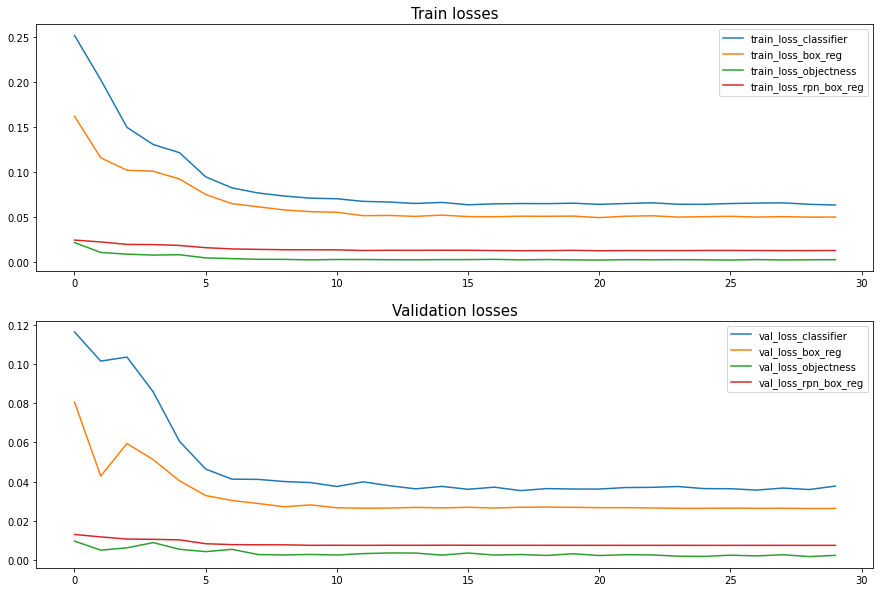

In [ ]:
losses_history_train_lc = losses_history_train['loss_classifier']
losses_history_train_br = losses_history_train['loss_box_reg']
losses_history_train_obj = losses_history_train['loss_objectness']
losses_history_train_rpn = losses_history_train['loss_rpn_box_reg']

losses_history_val_lc = losses_history_val['loss_classifier']
losses_history_val_br = losses_history_val['loss_box_reg']
losses_history_val_obj = losses_history_val['loss_objectness']
losses_history_val_rpn = losses_history_val['loss_rpn_box_reg']



fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

axes[0].plot(losses_history_train_lc, label='train_loss_classifier')
axes[0].plot(losses_history_train_br, label='train_loss_box_reg')
axes[0].plot(losses_history_train_obj, label='train_loss_objectness')
axes[0].plot(losses_history_train_rpn, label='train_loss_rpn_box_reg')
axes[0].legend(loc='best')
axes[0].set_title('Train losses', fontsize=15)

axes[1].plot(losses_history_val_lc, label='val_loss_classifier')
axes[1].plot(losses_history_val_br, label='val_loss_box_reg')
axes[1].plot(losses_history_val_obj, label='val_loss_objectness')
axes[1].plot(losses_history_val_rpn, label='val_loss_rpn_box_reg')
axes[1].legend(loc='best')
axes[1].set_title('Validation losses', fontsize=15)

plt.show()

In [ ]:
# model.load_state_dict(torch.load('/content/drive/My Drive/net_weights/weigths_at_epoch_30.pth'))

<All keys matched successfully>

In [ ]:
def iou_score(boxA, boxB):
    boxA = boxA.tolist()
    boxB = boxB.tolist()
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

def classify(predicted_boxes, target_boxes):
    TP, FP, FN = 0, 0, 0
    len_pr_boxes = len(predicted_boxes)
    len_tr_boxes = len(target_boxes)
    # create matrix (len_tr_boxes, len_pr_boxes). In rows IoU of target box with predict box, in cols IoU of predict with target
    iou_matrix = np.zeros((len_tr_boxes, len_pr_boxes))
    for i in range(iou_matrix.shape[0]):
        for j in range(iou_matrix.shape[1]):
            iou_matrix[i][j] = iou_score(target_boxes[i], predicted_boxes[j])
    # threshold 0.5 for IoU score
    iou_matrix = 1 * (iou_matrix > 0.5)
    # sum by col-axis, it gives amount of predicted boxes that aims target boxes by IoU score > 0.5
    iou_matrix = np.sum(iou_matrix, axis=1)
    for i in range(iou_matrix.shape[0]):
        if iou_matrix[i] == 0:
            FN += 1
        elif iou_matrix[i] == 1:
            TP += 1
        else:
            TP += 1
            FP += iou_matrix[i] - 1
    if np.sum(iou_matrix) <= len_pr_boxes:
        FP += len_pr_boxes - np.sum(iou_matrix)
    conf_mat = {}
    conf_mat['TP'] = TP
    conf_mat['FP'] = FP
    conf_mat['FN'] = FN
    return conf_mat
    

In [ ]:
def metric(model, dataset_loader):
    # class 1 - apple, class 2 - banana, class 3 - orange
    confusion_matrix = {1: {'TP': 0, 'FP': 0, 'FN': 0},
                        2: {'TP': 0, 'FP': 0, 'FN': 0},
                        3: {'TP': 0, 'FP': 0, 'FN': 0}}

    with torch.no_grad():
      model.eval()
      for i, data in enumerate(dataset_loader):
          image = []
          target = []
          for elem in data:
              image.append(elem['I'].cuda())
              target.append({k: v.cuda() for k, v in elem['T'].items()})
          prediction = model(image)

          CONF_THRESH = 0.85
          predicted_boxes = prediction[0]['boxes'][prediction[0]['scores'] > CONF_THRESH]
          predicted_labels = prediction[0]['labels'][prediction[0]['scores'] > CONF_THRESH]
          dict_predicted = {}
          dict_predicted['boxes'] = predicted_boxes.cpu()
          dict_predicted['labels'] = predicted_labels.cpu()
 
          dict_target = {}
          dict_target['boxes'] = target[0]['boxes'].cpu()
          dict_target['labels'] = target[0]['labels'].cpu()

          conf_matrix = {}
          for classes in range(1, 4):
              conf_matrix[classes] = classify(dict_predicted['boxes'][dict_predicted['labels'] == classes], dict_target['boxes'][dict_target['labels'] == classes])
              confusion_matrix[classes]['TP'] += conf_matrix[classes]['TP']
              confusion_matrix[classes]['FP'] += conf_matrix[classes]['FP']
              confusion_matrix[classes]['FN'] += conf_matrix[classes]['FN']
                        
          # visualize(image[0], dict_predicted)
          # visualize(image[0], dict_target)


    return confusion_matrix



In [ ]:
confusion_matrix = metric(model, data_loader_test)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [ ]:
class_1 = confusion_matrix[1]
class_2 = confusion_matrix[2]
class_3 = confusion_matrix[3]
print('Class 1. Precision = ', class_1['TP'] / (class_1['TP'] + class_1['FP']), 'Recall = ', class_1['TP'] / (class_1['TP'] + class_1['FN']), 'TP = ', class_1['TP'], 'FP = ', class_1['FP'], 'FN = ', class_1['FN'])
print('Class 2. Precision = ', class_2['TP'] / (class_2['TP'] + class_2['FP']), 'Recall = ', class_2['TP'] / (class_2['TP'] + class_2['FN']), 'TP = ', class_2['TP'], 'FP = ', class_2['FP'], 'FN = ', class_2['FN'])
print('Class 3. Precision = ', class_3['TP'] / (class_3['TP'] + class_3['FP']), 'Recall = ', class_3['TP'] / (class_3['TP'] + class_3['FN']), 'TP = ', class_3['TP'], 'FP = ', class_3['FP'], 'FN = ', class_3['FN'])

Class 1. Precision =  0.9411764705882353 Recall =  0.9142857142857143 TP =  32 FP =  2 FN =  3
Class 2. Precision =  0.8222222222222222 Recall =  0.7708333333333334 TP =  37 FP =  8 FN =  11
Class 3. Precision =  0.9545454545454546 Recall =  0.9333333333333333 TP =  42 FP =  2 FN =  3
